In [40]:
%matplotlib inline
%matplotlib widget
import os, sys

sys.path.append(os.path.join(".."))
from common import colorIntervals

#sys.path.append(os.path.join("..", ".."))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from stgem.generator import STGEMResult

In [41]:
def load_results(files):
    results = []
    for file in files:
        results.append(STGEMResult.restore_from_file(file))

    return results

In [42]:
"""Loads result object given a path and a prefix for the file (ex. 'F16_')"""
def load(path, prefix):
    files = [os.path.join(path, file) for file in os.listdir(path) if os.path.basename(file).startswith(prefix)]
    files.sort()
    return load_results(files)

output_path_base = os.path.join("..", "..", "..", "output")

specification = "F16"
experiments = ["F16", "F16_dense", "F16_batch", "F16_300", "F16_ne", "F16_lr1", "F16_uniform", "F16_uniform_keras"]

file_names = []
results = {}
for experiment in experiments:
    try:
        r = load(os.path.join(output_path_base, experiment), specification + "_") # "__mbsut_falsified"
    except FileNotFoundError: # Not all experiments have output data available
        pass
    if len(r) > 0:
        results[experiment] = r
        file_names.append(specification + "_")

In [43]:
def falsification_rate(results):
    c = 0
    for result in results:
        c += 1 if any(step.success for step in result.step_results) else 0

    return c/len(results)

print("Falsification rates:")
for experiment in experiments:
    print("{}: {}".format(experiment, falsification_rate(results[experiment])))


Falsification rates:
F16: 0.0
F16_dense: 0.0
F16_batch: 0.0
F16_300: 0.0
F16_ne: 0.0
F16_lr1: 0.0
F16_uniform: 0.0
F16_uniform_keras: 0.0


In [44]:
def min_along(X, length=None):
    # Return the minimum so far along X.
    m = 1.0
    A = []
    for i in range(len(X) if length is None else length):
        o = X[i] if i < len(X) else 1.0
        if o < m:
            m = o
        A.append(m)
    return A

def mean_min_along(results, length=None):
    A = []
    for i in range(len(results)):
        _, _, Y = results[i].test_repository.get()
        Y = [Y[i][0] for i in range(len(Y))]
        B = min_along(Y, length=length)
        A.append(B)

    A = np.array(A)
    C = np.mean(A, axis=0)

    return C

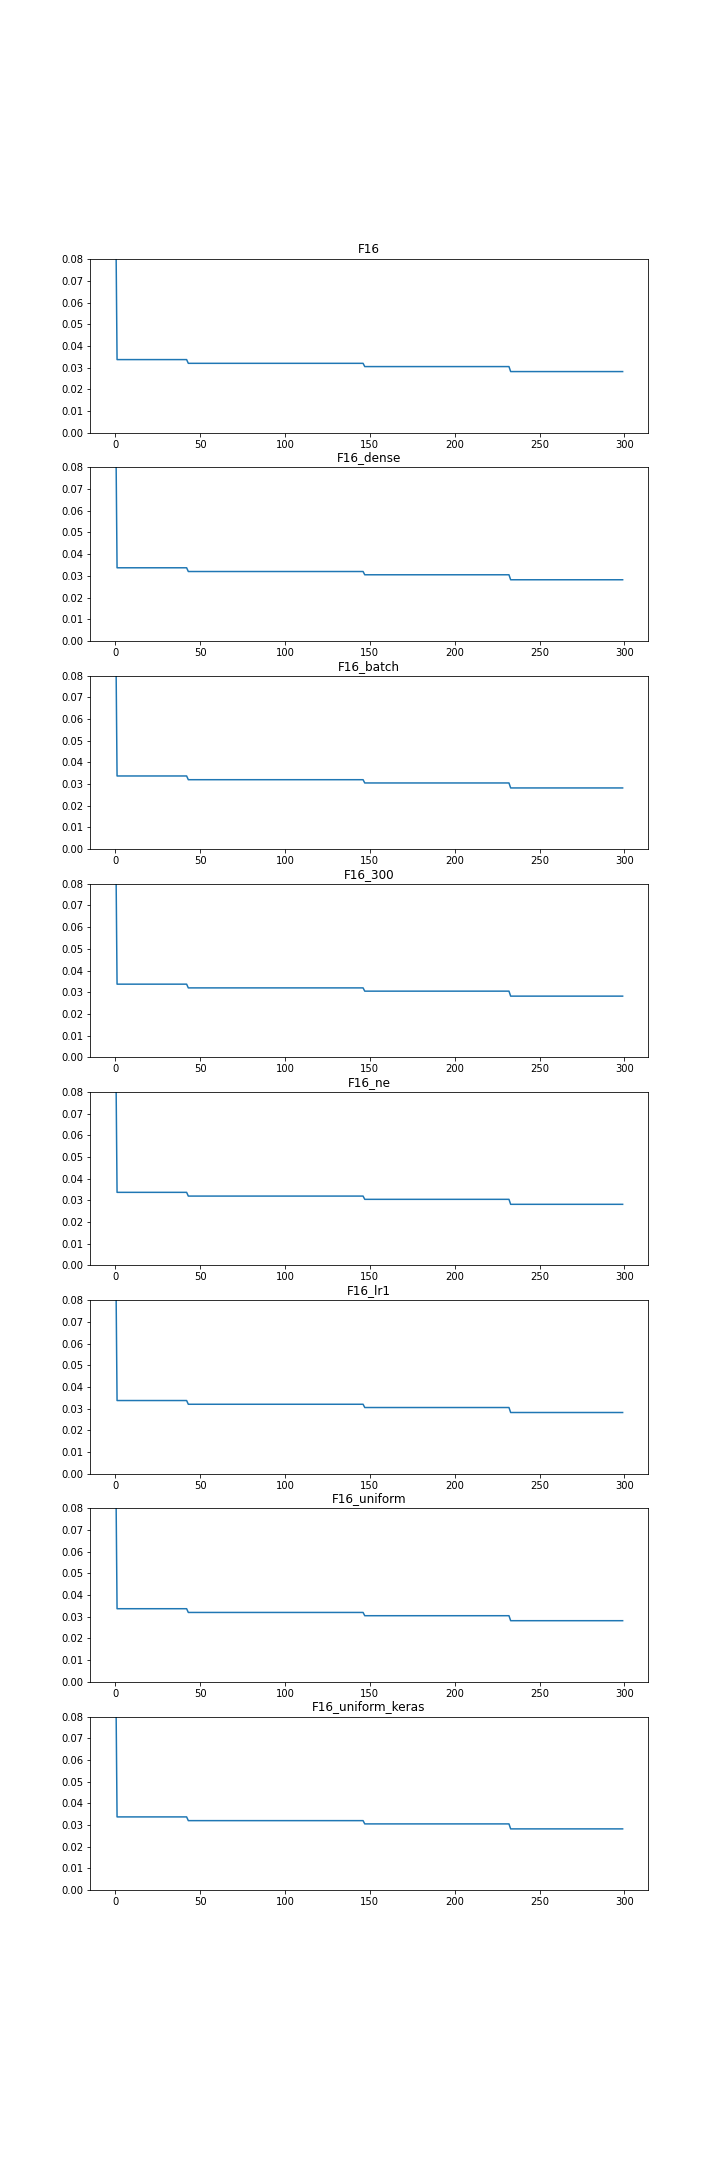

In [45]:
figs, axs = plt.subplots(len(experiments), 1, figsize=(10, 30))
for i, experiment in enumerate(experiments):
    A = mean_min_along(results[experiment], length=300)
    axs[i].set_title(experiment)
    axs[i].set_ylim(0.00, 0.08)
    axs[i].plot(A)

In [46]:
experiment = "F16"
idx = 0
i = 0
X, Z, Y = results[experiment][idx].test_repository.get()

print("Input:")
print("  ROLL = {}".format(X[i].inputs[0]))
print("  PITCH = {}".format(X[i].inputs[1]))
print("  YAW = {}".format(X[i].inputs[2]))

print("Robustness: {}".format(Y[i]))

if (Z[i].output_timestamps == None):
    print("<No plot due to no access to time stamps>")
else:
    fig, axs = plt.subplots(1, 1)
    fig.suptitle("Output signals:")
    axs.set_title("ALTITUDE")
    axs.minorticks_on()
    axs.plot(Z[i].output_timestamps, Z[i].outputs[0])


Input:
  ROLL = -0.9669247703596286
  PITCH = 0.2921405121226641
  YAW = 0.32452076843925814
Robustness: [array([0.12109143], dtype=float32)]
<No plot due to no access to time stamps>


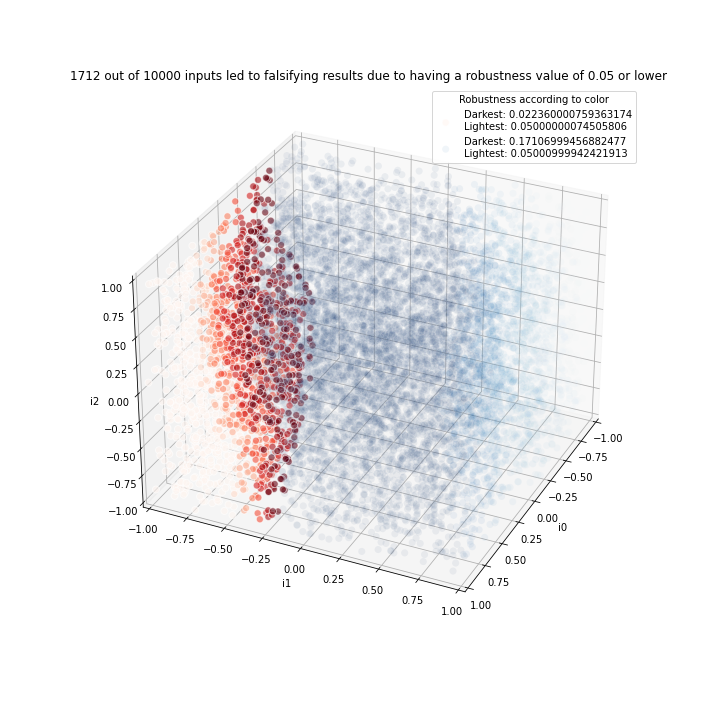

In [47]:
experiment = "F16"
idx = 0
angle = 25

X, _, Y = results[experiment][idx].test_repository.get()
X = np.asarray([x.inputs for x in X]) # Inputs
Y = np.asarray(Y).reshape(-1) # Robustness

try:
    sut_inputs = results[experiment][idx].sut_parameters["inputs"]
except KeyError: # sut_parameters are not always available
    sut_inputs = ["i{}".format(i) for i in range (len(X[idx]))] # Default input names "i0", "i1", ...


fig = plt.figure(figsize=(10, 10))

# Adding support for 2d and 1d
if (len(sut_inputs) == 1):
    ax = fig.add_subplot()#TODO: find acceptable one dimensional plot
    ax.set_xlabel(sut_inputs[0])
    ax.set_xlim(-1, 1)
elif (len(sut_inputs) == 2):
    ax = fig.add_subplot()
    ax.set_xlabel(sut_inputs[0])
    ax.set_xlim(-1, 1)
    ax.set_ylabel(sut_inputs[1])
    ax.set_ylim(-1, 1)
elif (len(sut_inputs) == 3):
    ax = fig.add_subplot(projection="3d") # 111
    ax.set_xlabel(sut_inputs[0])
    ax.set_xlim(-1, 1)
    ax.set_ylabel(sut_inputs[1])
    ax.set_ylim(-1, 1)
    ax.set_zlabel(sut_inputs[2])
    ax.set_zlim(-1, 1)
else:
    raise ValueError("Too many dimensions ({}) to visualize. Max amount {}".format(len(sut_inputs), 3)) #ValueError correct error?

ax.azim = angle # rotate around the z axis

# Color maps
color_map_false = cm.get_cmap("Reds", 8)
color_map_persist = cm.get_cmap("Blues_r", 8) # Inverted map
falsify_pct = 0.05 # Robustness percent needed for classifying as a falsified test

interval_false = [1, -1] # Min & Max robustness values
interval_persist = [1, -1]
c = list() # List for tracking input indexes that fail the test
# Save test fail indexes and set intervals
for i in range(len(X)):
    if (Y[i] <= falsify_pct):
        c.append(i)
        if (Y[i] < interval_false[0]):
            interval_false[0] = Y[i]
        if (Y[i] > interval_false[1]):
            interval_false[1] = Y[i]
    else:
        if (Y[i] < interval_persist[0]):
            interval_persist[0] = Y[i]
        if (Y[i] > interval_persist[1]):
            interval_persist[1] = Y[i]

# Initiate arrays
points_false = np.empty(shape=(len(c), len(sut_inputs)))
points_persist = np.empty(shape=(len(X)- len(c), len(sut_inputs)))
colors_false = np.empty(shape=(len(c), 4)) # color values use 4 float values, hence 4 dimensions
colors_persist = np.empty(shape=(len(X) - len(c), 4))

# split inputs into falsifying and persistent and calculate colors
f, p = 0, 0
for i in range(len(X)):
    if (i in c):
        points_false[f] = X[i]
        colors_false[f] = colorIntervals(Y[i], color_map_false, interval_false, (-1, 1)) # (-1, 0) = left side of colormap
        f += 1
    else:
        points_persist[p] = X[i]
        colors_persist[p] = colorIntervals(Y[i], color_map_persist, interval_persist, (-1, 1)) # (0, 1) = right side of colormap
        p += 1

def label(interval, invert_lightness=False):
    if invert_lightness:
        format = (round(interval[1], 5), round(interval[0], 5))
    else:
        format = (round(interval[0], 5), round(interval[1], 5))
    return "Darkest: {}\nLightest: {}".format(format[0], format[1])

# TODO: Implement multidimensional support
if (len(sut_inputs) == 1):
    pass
elif (len(sut_inputs) == 2):
    pass
elif (len(sut_inputs) == 3):
    ax.scatter(points_false[:, 0], points_false[:, 1], points_false[:, 2], s=50, alpha=0.6, edgecolors="w", c=colors_false, label=label(interval_false))
    ax.scatter(points_persist[:, 0], points_persist[:, 1], points_persist[:, 2], s=50, alpha=0.06, edgecolors="w", c=colors_persist, label=label(interval_persist, invert_lightness=True)) # Uses inverted map => invert label
else:
    raise ValueError("Too many dimensions ({}) to visualize. Max amount {}".format(len(sut_inputs), 3)) #ValueError correct error?

ax.set_title("{} out of {} inputs led to falsifying results due to having a robustness value of {} or lower".format(len(points_false) ,len(X) ,falsify_pct))
ax.legend(title="Robustness according to color", loc="upper right") # bbox_to_anchor=(1,1)

plt.show()